# Ozone Transformer Example

## Environments Setup

1. Create Python virtual environment named `venv`
   - `python -m venv venv`
2. Activate the new virtual environment `venv`
   - `source venv/bin/activate`
3. Install required python libraries from `ot_requirements.txt` file
   - `pip install -r ot_requirements.txt`
4. Select `venv` as python kernel for this JupyterNotebook

In [ ]:
import functools
import time
import os

from tqdm import tqdm

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import DataLoader, TensorDataset


## Config

In [ ]:
LOAD_PRETRAINED_MODEL = True
PATH_PRETRAINED_MODEL = "pretrained_model/ot.pth"

DATA_LOADER_BATCH_SIZE = 64
TRAINING_EPOCHS = 5

## Prepare Dataset

In [3]:
xr_ot = xr.open_dataset("data/mljc_workshop_o3_L25.nc")

In [4]:
ozone_arr = xr_ot["SpeciesConcVV_O3"].data
ozone_arr_trimmed = ozone_arr[:, :-2, :]

In [5]:
ozone_chunked = ozone_arr_trimmed.reshape(
    ozone_arr_trimmed.shape[0], 
    ozone_arr_trimmed.shape[1] // 11, 11, 
    ozone_arr_trimmed.shape[2] // 12, 12
).swapaxes(2, 3).swapaxes(0, 2)
ozone_chunked = ozone_chunked.reshape(-1, *ozone_chunked.shape[2:])

In [6]:
ozone_chunked_trimmed = ozone_chunked[:, :-20, :, :]

In [7]:
ozone_chunked = ozone_chunked_trimmed.reshape(
    ozone_chunked_trimmed.shape[0], 
    ozone_chunked_trimmed.shape[1] // 100, 100, 
    ozone_chunked_trimmed.shape[2], 
    ozone_chunked_trimmed.shape[3]
)
ozone_chunked = ozone_chunked.reshape(-1, *ozone_chunked.shape[2:])

In [8]:
ozone_chunked = ozone_chunked.reshape(*ozone_chunked.shape[:-2], -1)

Normalize by global mean and standard deviation

In [9]:
ozone_chunked = (ozone_chunked - np.mean(ozone_chunked)) / np.std(ozone_chunked)

In [10]:
MAP_SHAPE = (11, 12)

In [11]:
# ozone_chunked = ozone_chunked[:100]

In [12]:
ozone_chunked.shape

(696, 100, 132)

In [13]:
def shift_tensor_right(x, shift, dim):
    size = x.size(dim)
    if shift >= size:
        # Entire tensor becomes zero
        return torch.zeros_like(x)

    # Slice from start to size - shift along dim
    sliced = x.narrow(dim, 0, size - shift)

    # Pad with zeros at the beginning along that dimension
    pad_shape = list(x.shape)
    pad_shape[dim] = shift
    pad_tensor = torch.zeros(pad_shape, dtype=x.dtype, device=x.device)

    return torch.cat((pad_tensor, sliced), dim=dim)

shift_sequence_dim_right = functools.partial(shift_tensor_right, shift=1, dim=1)


The dimension of the dataset: (batch_size, sequence_size, embedding_size)

We have following dataset:
- input: `ozone_chunked`
- output: `ozone_chunked_shifted`

In [14]:
SRC_train, SRC_test = train_test_split(ozone_chunked, train_size=0.8)

In [15]:
SRC_train = torch.tensor(SRC_train)
SRC_test  = torch.tensor(SRC_test)

In [16]:
TGT_train = shift_sequence_dim_right(SRC_train)
TGT_test = shift_sequence_dim_right(SRC_test)

Divided into train and test dataset (let's ignore validation datasets)
- Train:
    - `SRC_train`
    - `TGT_train`
- Test:
    - `SRC_test`
    - `TGT_test`

In [17]:
dataset_train = TensorDataset(SRC_train, TGT_train)
dataset_test = TensorDataset(SRC_test, TGT_test)

dataloader_train = DataLoader(dataset_train, batch_size=DATA_LOADER_BATCH_SIZE, shuffle=True)
dataloader_test = DataLoader(dataset_test, batch_size=DATA_LOADER_BATCH_SIZE, shuffle=True)

## Model Setup

In [18]:
def get_sinusoidal_positional_embedding(sequence_size, embedding_size):
    pos = torch.arange(0, sequence_size, dtype=torch.float).unsqueeze(1)
    i = torch.arange(0, embedding_size, 2).float()
    angle_rates = 1 / (10000 ** (i / embedding_size))
    
    angle_rads = pos * angle_rates  # [seq_len, d_model/2]

    pe = torch.zeros(sequence_size, embedding_size)
    pe[:, 0::2] = torch.sin(angle_rads)
    pe[:, 1::2] = torch.cos(angle_rads)

    return pe  # [seq_len, d_model]

In [19]:
EMBEDDING_SIZE = SRC_test.shape[2]
SEQUENCE_SIZE = SRC_train.shape[1]

In [20]:
class TransformerModel(torch.nn.Module):
    def __init__(
            self, 
            embedding_size, 
            n_head, n_encoder_layer, n_decoder_layer, n_feedforward, 
            positional_embedding_func,
            sequence_dim_shift_func,
        ):
        super(TransformerModel, self).__init__()

        self.positional_encoding_func = positional_embedding_func
        self.sequence_dim_shift_func = sequence_dim_shift_func

        self.transformer = torch.nn.Transformer(
            embedding_size, 
            n_head, 
            n_encoder_layer, 
            n_decoder_layer, 
            n_feedforward, 
            batch_first=True
        )
        
    def forward(self, x):
        tgt_mask = torch.nn.Transformer.generate_square_subsequent_mask(x.shape[1])
        
        x += self.positional_encoding_func(x.shape[1], x.shape[2]).to(x.device)
        x_shifted = self.sequence_dim_shift_func(x)
        x = self.transformer(x, x_shifted, tgt_mask=tgt_mask)

        return x

## Training

**Logging Setups**

In [21]:
num_epochs = TRAINING_EPOCHS
train_losses = np.zeros(num_epochs)
train_accuracies = np.zeros(num_epochs)

test_losses = np.zeros(num_epochs)
test_accuracies = np.zeros(num_epochs)

**Model Setups**

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

num_heads = 12 # EMBEDDING_SIZE (default = 132) must be divisible by num_heads
num_encoder_layers = 4
num_decoder_layers = 4
feed_forward_layer_size = 1024

model = TransformerModel(EMBEDDING_SIZE, num_heads, num_encoder_layers, num_decoder_layers, feed_forward_layer_size, get_sinusoidal_positional_embedding, shift_sequence_dim_right)
model.to(device)

loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Using device: cuda


In [23]:
print(model.parameters)

<bound method Module.parameters of TransformerModel(
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-3): 4 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=132, out_features=132, bias=True)
          )
          (linear1): Linear(in_features=132, out_features=1024, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=1024, out_features=132, bias=True)
          (norm1): LayerNorm((132,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((132,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
      (norm): LayerNorm((132,), eps=1e-05, elementwise_affine=True)
    )
    (decoder): TransformerDecoder(
      (layers): ModuleList(
        (0-3): 4 x TransformerDecoderLayer(
   

In [24]:
def train_epoch(model, train_loader, loss_fn, optimizer):
    global device

    model.train()
    epoch_loss = 0
    epoch_accuracy = 0
    # total_batches = 0
    total_batches = len(train_loader)
    
    for ozone_seq, ozone_seq_shifted in tqdm(train_loader, "Training"):
        
        ozone_seq, ozone_seq_shifted = ozone_seq.to(device), ozone_seq_shifted.to(device)
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(ozone_seq)
        
        # Compute loss and gradients
        loss = loss_fn(outputs, ozone_seq_shifted)
        loss.backward()
        
        # Update model parameters
        optimizer.step()
        
        # Calculate accuracy
        accuracy = loss.item()
        
        epoch_loss += loss.item()
        epoch_accuracy += accuracy
    
    return epoch_loss / total_batches, epoch_accuracy / total_batches

def evaluate(model, test_loader, loss_fn):
    global device
    
    model.eval()
    epoch_loss = 0
    epoch_accuracy = 0
    total_batches = len(test_loader)
    
    with torch.no_grad():
        for ozone_seq, ozone_seq_shifted in tqdm(test_loader, "Evaluating"):
            ozone_seq, ozone_seq_shifted = ozone_seq.to(device), ozone_seq_shifted.to(device)
            # Forward pass
            outputs = model(ozone_seq)
            
            # Compute loss
            loss = loss_fn(outputs, ozone_seq_shifted)
            
            # Calculate accuracy
            accuracy = loss.item()
            
            epoch_loss += loss.item()
            epoch_accuracy += accuracy
    
    return epoch_loss / total_batches, epoch_accuracy / total_batches

In [ ]:
if not LOAD_PRETRAINED_MODEL:
    for epoch in range(num_epochs):
        start_time = time.time()
        
        # Train for one epoch
        train_loss, train_accuracy = train_epoch(model, dataloader_train, loss_fn, optimizer)
        train_losses[epoch] = train_loss
        train_accuracies[epoch] = train_accuracy
        
        # Evaluate on the test set
        test_loss, test_accuracy = evaluate(model, dataloader_test, loss_fn)
        test_losses[epoch] = test_loss
        test_accuracies[epoch] = test_accuracy
        end_time = time.time()
        
        print(f"Epoch [{epoch+1}/{num_epochs}] | Time: {end_time - start_time:.2f}s")
        print(f"Train Loss: {train_loss:.4f} \t| Train Accuracy: {train_accuracy:.4f}")
        print(f"Test Loss: {test_loss:.4f}   \t| Test Accuracy: {test_accuracy:.4f}")

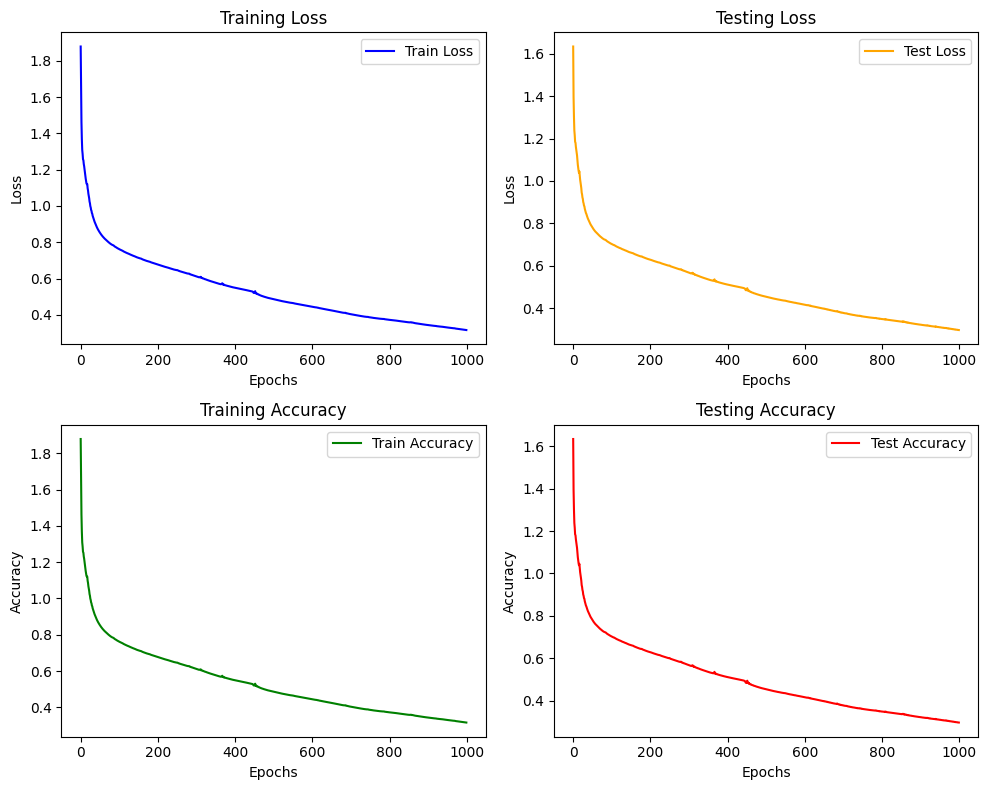

In [26]:
if not LOAD_PRETRAINED_MODEL:
    epochs = list(range(0, num_epochs))

    # Create 2x2 grid of subplots using plt.subplot
    plt.figure(figsize=(10, 8))

    # Training Loss
    plt.subplot(2, 2, 1)  # (rows, columns, index)
    plt.plot(epochs, train_losses, color='blue', label='Train Loss')
    plt.title('Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Testing Loss
    plt.subplot(2, 2, 2)
    plt.plot(epochs, test_losses, color='orange', label='Test Loss')
    plt.title('Testing Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Training Accuracy
    plt.subplot(2, 2, 3)
    plt.plot(epochs, train_accuracies, color='green', label='Train Accuracy')
    plt.title('Training Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Testing Accuracy
    plt.subplot(2, 2, 4)
    plt.plot(epochs, test_accuracies, color='red', label='Test Accuracy')
    plt.title('Testing Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Adjust layout and display
    plt.tight_layout()
    plt.show()

In [27]:
print(f"Final Training Accuracy {train_accuracies[-1]};\tTesting Accuracy {test_accuracies[-1]}")

Final Training Accuracy 0.316674143075943;	Testing Accuracy 0.29606372117996216


In [ ]:
if not LOAD_PRETRAINED_MODEL:
    model_saved_path = r'trained_model/' 
    if not os.path.exists(model_saved_path):
        os.makedirs(model_saved_path)
    torch.save(model.state_dict()   , f"{model_saved_path}/ot.pth")

## Inference

In [ ]:
if LOAD_PRETRAINED_MODEL:
    model.load_state_dict(torch.load(PATH_PRETRAINED_MODEL, weights_only=True, map_location=device))
    model.to(device)
    
model.eval()

TransformerModel(
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-3): 4 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=132, out_features=132, bias=True)
          )
          (linear1): Linear(in_features=132, out_features=1024, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=1024, out_features=132, bias=True)
          (norm1): LayerNorm((132,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((132,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
      (norm): LayerNorm((132,), eps=1e-05, elementwise_affine=True)
    )
    (decoder): TransformerDecoder(
      (layers): ModuleList(
        (0-3): 4 x TransformerDecoderLayer(
          (self_attn): MultiheadAttent

In [30]:
PRED_test = model(SRC_test.to(device)).to("cpu").detach().numpy()
OBS_test = TGT_test.detach().numpy()

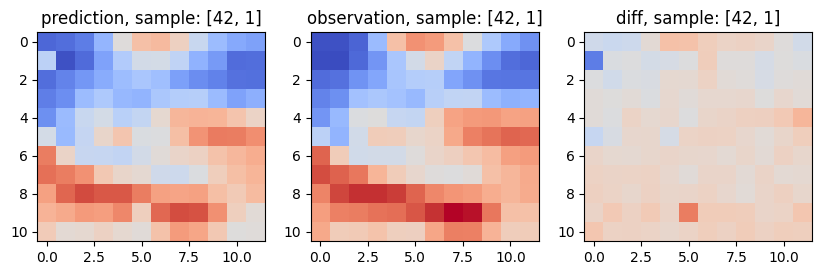

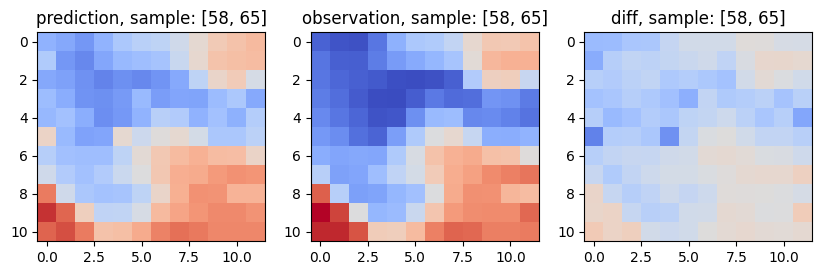

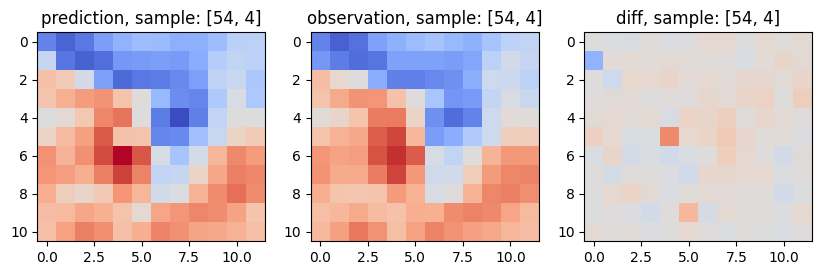

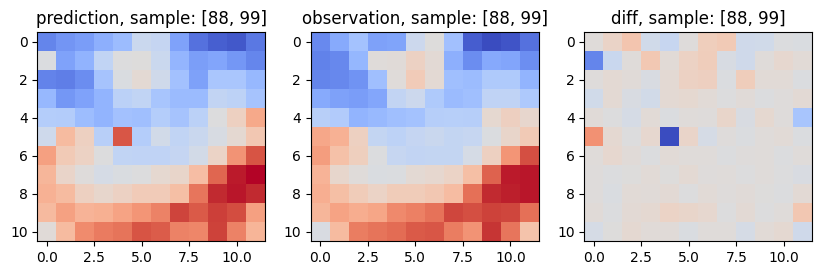

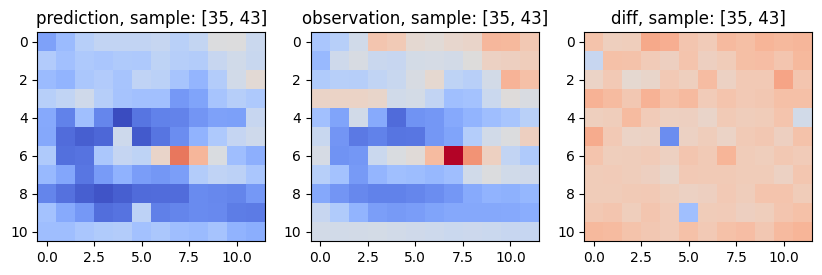

In [32]:
for _ in range(5):
    bb = np.random.randint(OBS_test.shape[0])
    ss = np.random.randint(OBS_test.shape[1])
    
    color_range = np.array((
        np.min(np.concatenate([OBS_test[bb, ss], PRED_test[bb, ss]])), 
        np.max(np.concatenate([OBS_test[bb, ss], PRED_test[bb, ss]]))
    ))
    
    color_range_centered = color_range - np.mean(color_range)
    
    fig, (ax_pred, ax_obs, ax_error) = plt.subplots(1, 3, figsize=(10, 3),)

    ax_pred.imshow(PRED_test[bb, ss].reshape(MAP_SHAPE), vmin=color_range[0], vmax=color_range[1], cmap="coolwarm")
    ax_pred.set_title(f"prediction, sample: {[bb, ss]}")

    ax_obs.imshow(OBS_test[bb, ss].reshape(MAP_SHAPE), vmin=color_range[0], vmax=color_range[1], cmap="coolwarm")
    ax_obs.set_title(f"observation, sample: {[bb, ss]}")
    
    ax_error.imshow(OBS_test[bb, ss].reshape(MAP_SHAPE) - PRED_test[bb, ss].reshape(MAP_SHAPE), vmin=color_range_centered[0], vmax=color_range_centered[1], cmap="coolwarm")
    ax_error.set_title(f"diff, sample: {[bb, ss]}")

    
    plt.show()